In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import dit
import admUI
import math

# Introduction

Information and its theory are an important quantity that govern many fields, rangning from communication to machine learning.  In this tutorial, we are going to demonstate a novey approach of decomposing information into parts. Each part describes a certain aspect of the relationship of the variables.


We start the turotial with dataset description and some preprocessing steps ([Section 2](#Data-Preparation)). Then, we define some auxiliary functions for visualizing results. Then, we talk about the foundation of information theory ([Section 3](#Basic-Information-Theory)) and Information Decomposition ([Section 4](#Information-Decomposition)). Thorough this tutorial, we provide code that implement or compute quantities of current interests.

# Data Preparation

In this tutorial, we use **[US Census 1994][us-census]**, a publily available dataset,  to demonstate the content of this turorial. The dataset contains individual's attributes, such as race, age, gender, and the level of income ( <= X, > X ). Hence, ML learners use it to train a classifier for predicting the level of income based on other attributes.


Here, we are interested in explaing the relationship between these attributes and the income variable; therefore, we only use the training set.

[us-census]: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

In [3]:
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "martital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]


df = pd.read_csv(data_url, names=column_names)

## Cleansing

In [4]:
# data exploration

df[:5]

,age,workclass,fnlwgt,education,education-num,martital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df[:1].values

array([[39, ' State-gov', 77516, ' Bachelors', 13, ' Never-married',
        ' Adm-clerical', ' Not-in-family', ' White', ' Male', 2174, 0,
        40, ' United-States', ' <=50K']], dtype=object)

As you can see from the above, some attributes (columns) contains a space in the begining. Although these spaces do not
affect our computation, it is still good to clean it up. 

This can been done by finding string columns (stored as `object`) and use Python's `strip` function to remove these prefix spaces.

In [6]:
for k, v in zip(column_names, df.dtypes):
    if v == "object":
        df[k] = df[k].apply(lambda x: x.strip())

## Discretization

As you can see from the data exploration part, `age` and `hours-per-week` are continuous. This might be useful for some cases to treat them as they are. In this tutorial, we are interested in only groups of these values. Therefore, we need first need to perform discretization on this values. More precisely,

- We categorize `age` into four groups: [ '<24', '24-35', '36-50', '>50' ], and
- We group `hours_per_week_group` into two groups: ['<=40', '>40']

In [7]:
age_groups = ['<24', '24-35', '36-50', '>50']
df['age-group'] = df.age.apply(lambda x: age_groups[np.digitize(x, [24, 36, 51])])

hours_per_week_group = ['<=40', '>40']
df['hours-per-week-group'] = df['hours-per-week'].apply(lambda x: hours_per_week_group[0 if x <= 40 else 1])

## Data Distribution

Once we have finished cleansing and discretizing the data, we are now ready to instantiate a [dit][dit]'s `Distribution` variable. This variable comes with necessary methods for dealing probabilistic operators, such as marginalization and conditioning.

[dit]: https://github.com/dit/dit

In [8]:
# select only columns that we will use in this tutorial
selected_columns = [
    'income',
    'education',
    'sex',
    'race',
    'occupation',
    'age-group',
    'hours-per-week-group'
]

# aliases
rvs_names = [
    'S',  # income
    'E',  # education
    'G',  # sex
    'R',  # race
    'O',  # occupation
    'A',  # age
    'H',  # hours-per-week
]

rvs_to_name = dict(zip(rvs_names, selected_columns))

In [9]:
# take all samples with attributes that we're interested in 
data_array = list(map(lambda r: tuple(r[k] for k in selected_columns), df.to_dict("record")))

# create distribution from the samples with uniform distribution
dist_census = dit.Distribution(data_array, [1. / df.shape[0] ] * df.shape[0])

# set variable aliases to the discribution
dist_census.set_rv_names("".join(rvs_names))

In [10]:
# marginal distribution of P(G), G is `sex`
dist_census.marginal('G')

Class:,Distribution
Alphabet:,"('Female', 'Male') for all rvs"
Base:,linear
Outcome Class:,tuple
Outcome Lenght:,1
G,p(x)
Female,0.33079450876815825
Male,0.6692054912318418


In [11]:
# conditional probablity P(S|G).
marginal, cdists = dist_census.condition_on('G', rvs='S')

for i, (c, d) in enumerate(zip(cdists, marginal.zipped())):
    print("")
    print("-----------------------")
    print("Marginal: %s | %f" % d)
    print("P(S|H='%s')" % (d[0]))
    print(c)


-----------------------
Marginal: ('Female',) | 0.330795
P(S|H='Female')
Class:          Distribution
Alphabet:       ('<=50K', '>50K') for all rvs
Base:           linear
Outcome Class:  tuple
Outcome Length: 1
RV Names:       ('S',)

x            p(x)
('<=50K',)   0.8905394113824158
('>50K',)    0.10946058861758425

-----------------------
Marginal: ('Male',) | 0.669205
P(S|H='Male')
Class:          Distribution
Alphabet:       ('<=50K', '>50K') for all rvs
Base:           linear
Outcome Class:  tuple
Outcome Length: 1
RV Names:       ('S',)

x            p(x)
('<=50K',)   0.6942634235888022
('>50K',)    0.3057365764111978


# Basic Information Theory

[note: revise this paragraph, make it relevant to what we're trying to do]

Information theory is a foundation of many fields and technologies. The theory provides rigourous methods that enable us to develop reliable ways of communication between senders and receivers via **noisy** channels. It is also a lens that helps us analyzing relationships between variables in pricipled ways. 

Some important quantities in Information Theory are:

## Entropy
Let $X$ be a discreate random variable.  Random variable $X$ takes values from $\mathcal{X}$ and has probability mass function $p(x) = P\{X=x\}, x \in \mathcal{X} $.

**Definition:** Entropy $H(X)$ of a discrete random variable $X$  is defined by

$$
H(X) = - \sum_{x \in \mathcal{X} } p(x) \log_{2} p(x).
$$

Because of $\log_2$ in the equation, it is measured in terms of *bits*, and we omit writing the base of the log from now onwards.

In [12]:
# H(G)
p_G = dist_census.marginal('G')
dit.shannon.entropy(p_G)

0.9157360598501509

### Joint Entropy and Contional Entropy

Let $(X, Y)$ be a pair of discrete random variable with a joint distribution $p(x,y)$, $x \in \mathcal{X}$ and $y \in \mathcal{Y}$.

**Definition:** Joint Entropy $H(X,Y)$ is definied by

$$
H(X, Y) = - \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x, y) \log p(x, y)
$$

In [13]:
# H(S, G)
p_SG = dist_census.marginal('SG')
dit.shannon.entropy(p_SG)

1.674948627614043

**Definition:** Conditional Entropy $H(Y|X)$ is defined by 

$$
H(Y|X) = - \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x, y) \log p(y|x)
$$

In [14]:
# H(S|G)
dit.shannon.conditional_entropy(dist_census, 'S', 'G') 

0.7592125677638922

**Theorem:** Chain Rule of Joint Entropy $H(X, Y)$

$$
H(X, Y) = H(X) + H(Y|X)
$$

Proof can be found at [Cover, Thomas M and Thomas, Joy A's Elements of Information Theory, Theorem 2.2.1][element].

Below, we verify the theorem computationally.

[element]: https://www.wiley.com/en-it/Elements+of+Information+Theory,+2nd+Edition-p-9780471241959

In [15]:
dit.shannon.entropy(p_SG) \
    == dit.shannon.entropy(p_G) + dit.shannon.conditional_entropy(dist_census, 'S', 'G') 

True

## Relative Entropy

Let $p$ and $q$ be two distributions with probability mass function $p(x)$ and $q(x)$ accordingly. Relative entropy is a distance between $p$ and $q$.

**Definition:** Relative entropy between two distributions $p$ and $q$ $D(p\|q)$ is defined by 

$$
D(p\|q) = \sum_{x \in \mathcal{X}} p(x) \log \frac{p(x)}{q(x)}
$$

Another name of relative entropy is **Kullback-Leibler** divergence. Important properties of $D(p\|q)$ are:
- $D(p\|q) \neq D(q\|p)$
- $D(p\|q) = 0$ iff.  $p=q$ 
- $D(p\|q) = \infty $ if there is some $x \in \mathcal{X}$ that $p(x) > 0$ and $q(x) = 0$.

## Mutual Information

For two discrete random variables $X$ and $Y$ with a joint probability $p(x, y)$ and marginal probablity mass function $p(x)$ and $p(y)$. 


**Definition:** Mutual information $I(X; Y)$ is the relative entropy between $p(x, y)$ and $p(x)p(y)$: 

$$
\begin{align*}
I(X; Y) &= D \big(p(x, y) \| p(x)p(y) \big) \\
&= \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \log \frac{p(x, y)}{p(x)p(y)}
\end{align*}
$$

If we derive it further, we have

$$
\begin{align*}
I(X; Y) &= \sum_{x \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \log \frac{p(x, y)}{p(x)p(y)} \\
&= \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \big( \log p(x, y) -  \log p(x) - \log p(y) \big) \\
&= - H(X, Y) - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \log p(x) - \sum_{x \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x, y) \log p(y) \\
&= H(X) + H(Y) - H(X, Y)
\end{align*}
$$

In [16]:
dit.shannon.mutual_information(dist_census, 'S', 'G')

0.037171387438320824

### Contitional Mutual Information

**Definition:** For three discrete random variables $X, Y, Z$, the conditional mutual information $I(X; Y |Z)$ is defined by

$$
I(X; Y |Z) = H(X|Z) - H(X|Y,Z).
$$

In [17]:
# I(S, H | O)
dit.shannon.conditional_entropy(dist_census, 'S', 'O') - \
 dit.shannon.conditional_entropy(dist_census, 'S', 'HO')

0.02187436337675841

# Information Decomposition

Let consider the setting that we have three random variables $X, Y, Z$. We are interested in knowing about $X$, but it is not observable. We can only observe the values of $Y$ and $Z$. 
![](https://i.imgur.com/GpHQ6MW.png)

Utimately, we would like to quantify how much we know about $X$ based on the information of $Y$ and $Z$. More precisely, $I(X; (Y, Z))$ is the total information of $X$ that $(Y, Z)$ contains.


[Bertschinger et al. (2014)][paper] proposes one approach to decompose $I(X; (Y, Z))$ into four quantities:


![](https://i.imgur.com/c3tEced.png)

$$
I(X; Y, Z) = SI(X; Y, Z) + CI(X; Y, Z) + UI(X; Y \backslash Z) + UI(X; Z \backslash Y),
$$

where 
- $SI(X; Y, Z)$ is shared information that both $Y$ and $Z$ have about $X$,
- $CI(X; Y, Z)$ is complimentary (synergic) information that $Y$ and $Z$ have about $X$ when considering them together,
- $UI(X; Y \backslash Z)$ is unique information that only $Y$ has about $X$ (in respect to $Z$), and vice versa. 

With the formulation above, these four quantities have to be non-negative.

## Shared Information
Furthermore, we have the following equilities:

$$
\begin{align*}
 SI(X; Y, Z) = I(X; Y) -  UI(X; Y \backslash Z) = I(X; Z) - UI(X; Z \backslash Y) \\
\end{align*}
$$


[paper]: https://www.mdpi.com/1099-4300/16/4/2161

## Co-Information

**Definition:** Previouly known as **interaction information** [(McGill W. (1994)][mcgill], co-Information $CoI(X;Y;Z)$ is defined by

$$
CoI(X;Y;Z) = I(X;Y) - I(X;Y|Z).
$$

With the chain rule of mutual information, we can write the identity above as

$$
CoI(X;Y;Z) = SI(X; Y, Z) - CI(X; Y, Z).
$$

[mcgill]: https://ieeexplore.ieee.org/abstract/document/1057469


In [18]:
# compute CoI(S; E; G) using dit
dit.multivariate.coinformation(dist_census, 'SEG')

-0.00010688124181967851

In [19]:
# compute CoI(S; H; G) using dit
dit.multivariate.coinformation(dist_census, 'SHG')

0.012185581661140699

## Unique Information

From above, we have everything in place except $UI(\cdot)$ that we haven't defined yet. Bertschinger et al. (2014) define the unique information as follows:

$$
UI(X; Y \backslash Z) = \min_{Q \in \Delta_p} I_Q(X; Y|Z), 
$$

where $\Delta_p$ is a set of joint probability distributions that have the same marginal probablity distributions on $(X, Y)$ and $(X, Z)$ as $P \in \mathbb{P}_{ \mathcal{X} \times \mathcal{Y} \times \mathcal{Z} }$.

Formally, $\Delta_p$ is

$$
\Delta_p = \{ Q \in \mathbb{P}_{ \mathcal{X} \times \mathcal{Y} \times \mathcal{Z} }:  Q(X, Y) = P(X, Y) \text{ and } Q(X, Z) = P(X, Z) \}
$$

In [20]:
# find q for S, G, R (income, race, gender)
q_SGR = admUI.computeQUI(distSXY = dist_census.marginal('SGR'))

# due to the fact that computeQUI rename variables to SXY
# we need to rename them back to SRG
q_SGR.set_rv_names("SGR")

In [21]:
q_SGR

In [22]:
# H(S|G,R)
h_SgGR =  dit.shannon.conditional_entropy(q_SGR, 'S', 'GR')

# UI(S; G \ R) = I_Q { S; G \ R }
ui_SG_R = dit.shannon.conditional_entropy(q_SGR, 'S', 'R') - h_SgGR

ui_SG_R

0.028813064495489815

In [23]:
# UI(S; R \ G) = I_Q { S; R \ G }
ui_SR_G = dit.shannon.conditional_entropy(q_SGR, 'S', 'G') - h_SgGR

ui_SR_G 

1.9623869407237038e-05

In [24]:
# compute shared information
si_SGR = dit.shannon.mutual_information(q_SGR, 'S', 'G') - ui_SG_R 
si_SRG = dit.shannon.mutual_information(q_SGR, 'S', 'R') - ui_SR_G

# sanity check: by the definition of shared information
si_SGR == si_SRG

True

In [25]:
# by the definition of co-information
ci_SGR = si_SRG - dit.multivariate.coinformation(q_SGR, 'SGR')
ci_SGR

0.0

In [26]:
# sanity check: by the definition of Bertschinger et al. (2014)'s information decomposition
dit.shannon.mutual_information(q_SGR, 'S', 'GR') == ui_SG_R + ui_SR_G + si_SRG + ci_SGR 

True

# Result Visualization

In [27]:
# define measurement metrics
metric_keys = ['si', 'ci', 'ui_0', 'ui_1']

# define legend labels
latex_labels = [
    '$SI$',
    '$CI$',
    '$UI(S; Y \\backslash Z)$',
    '$UI(S; Z \\backslash Y)$'
]

# define colour for ploting
colors = [
    '#27AB93',
    '#FF5716',
    '#D33139',
    '#522F60',
] 

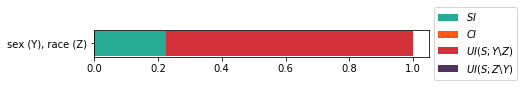

In [28]:
"""
define a auxiliary function which takes an array of

    {
        "variables": ["variable_0", "variable_1"],
        "metrics": {
            "mi": ...,
            "si": ..., 
            "ci": ...,
            "ui_0": ...,
            "ui_1": ...
        }
    },

"""


def plot(data):
    
    # definte the size of figure
    plt.figure(figsize=(6, 0.5*len(data)))
    
    labels = []
    metrics = []
    
    # suffix each variable name with an alias {Y, Z}
    for v in data:
        labels.append(", ".join(map(lambda p: "%s (%s)" % p, zip(v['variables'], ['Y', 'Z']))))
    
    for m in metric_keys:
        mm = []
        # extract corresponding metric from elements in array
        for v in data:
            mm.append(v['metrics'][m]/v['metrics']['mi'])
        metrics.append(mm)
    

    left = np.array([0]*len(labels))
    
    # plotting
    for i, kk in enumerate(metric_keys):
        plt.barh(
            labels, metrics[i], align='center', height=.5, left=left, label=latex_labels[i],color=colors[i],
        )
        left = left + metrics[i]
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot([
    {
        "variables": ["sex", "race"],
        "metrics": {
            "mi": dit.shannon.mutual_information(q_SGR, 'S', 'RG'),
            "si": si_SGR, 
            "ci": ci_SGR,
            "ui_0": ui_SG_R,
            "ui_1": ui_SR_G,
        }
    },
])

From the figure above, we can see that `sex(Y)` contains substantial amount of information about `income(S)`, while `race(Z)` does not. Futhermore, the two attributes `sex(Y)` and `race(Z)` also share some information about `income(S)` but not in a complementary manner.

## Other variable pairs

In the following, we are going to compute the information decomposition between `income` and several pairs of variables, namely

- education and sex
- education and race
- race and occupation
- age-group and sex
- hours-per-week-group and occupation.

We first define a function that computes the decomposition for us.

In [29]:
def information_decomposition(dist, src, to=""):
    rvs = src+to
    
    P = dist.marginal(rvs)
    
    variables = P._rvs
    
    q_SXY = admUI.computeQUI(distSXY = P)
    
    h_SgXY =  dit.shannon.conditional_entropy(q_SXY, 'S', 'XY')
    
    ui_SX_Y = dit.shannon.conditional_entropy(q_SXY, 'S', 'Y') - h_SgXY
    ui_SY_X = dit.shannon.conditional_entropy(q_SXY, 'S', 'X') - h_SgXY

    si_SXY_1 = dit.shannon.mutual_information(q_SXY, 'S', 'X') - ui_SX_Y
    si_SXY_2 = dit.shannon.mutual_information(q_SXY, 'S', 'Y') - ui_SY_X
    
    # sanity check
    assert math.isclose(si_SXY_1, si_SXY_2, abs_tol=1e-6), "SI_S_XY: %f | %f" % (si_SXY_1, si_SXY_2)

    si_SXY = si_SXY_1
    
    ci_SXY = si_SXY - dit.multivariate.coinformation(P, rvs)
    i_S_XY = dit.shannon.mutual_information(P, 'S', to)       

    # sanity check
    assert math.isclose(i_S_XY, si_SXY + ci_SXY + ui_SX_Y + ui_SY_X, abs_tol=1e-6), \
        "MI = decompose : %f | %f" % (i_S_XY, si_SXY + ci_SXY + ui_SX_Y + ui_SY_X)
    
    uis = [ui_SX_Y, ui_SY_X]
    return {
        "variables": tuple(map(lambda x: rvs_to_name[x], to)),
        "metrics": {
            "mi": i_S_XY,
            "si": si_SXY, 
            "ci": ci_SXY,
            "ui_0": uis[variables[to[0]]-1] ,
            "ui_1": uis[variables[to[1]]-1]
        }
    }

decomp_S_HO = information_decomposition(dist_census, 'S', 'HO')

In [30]:
decomp_S_EG = information_decomposition(dist_census, 'S', 'EG')

In [31]:
decomp_S_ER = information_decomposition(dist_census, 'S', 'ER')

In [32]:
decomp_S_RO = information_decomposition(dist_census, 'S', 'RO')

In [33]:
decomp_S_AG = information_decomposition(dist_census, 'S', 'AG')

In [34]:
# didn't converge, should we remove it?
# decomp_S_EO = compute_decomposition_from(dist_census, 'S', ['E', 'O'])

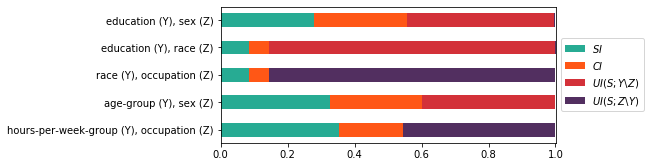

In [35]:
plot([
    decomp_S_EG,
    decomp_S_ER,
    decomp_S_RO,
    decomp_S_AG,
    decomp_S_HO,
][::-1])

When looking at `education` and `sex`, we can see that `education` uniquely contains considerable amount of information about `income` with respect to `sex`. The proportion is also large than what they convey about `income` in both shared and complementary aspects. Notably, `education` have large unique information about `income` when considering with `race`, and `occupation` also has a similar relative portion with respect to `race`.

This way of decomposition provides us a new aspect for analyzing the interactions between variables (predictors and responses) at a granular level.